# Petals to the Metal Competition
- Creating a Flow Classifier from a provided dataset
- Will be using tensorflow to practice multiclassification with deeplearning and images

In [2]:
import tensorflow as tf
from kaggle_datasets import KaggleDatasets
import numpy as np

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.15.0


In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU', tpu.master())
except ValueError:
    tpu = None
    print('No accelerator connected')
    
if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu) 
    strategy = tf.distribute.TPUStrategy(tpu) # TPU strat no longer experimental
else:
    strategy = tf.distribute.get_strategy() # default distribution strat for Tensorflow
    
print("REPLICAS: ", strategy.num_replicas_in_sync)
    

Running on TPU 
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


2024-02-09 23:10:11.055889: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-02-09 23:10:11.056010: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-02-09 23:10:11.056094: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-02-09 23:10:11.056178: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-02-09 23:10:11.056246: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-02-09 23:10:11.056490: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-02-09 23:10:11.056590: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this 

INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

## Load in Dataset

In [66]:
GCS_DS_PATH = '/kaggle/input/tpu-getting-started'
print(GCS_DS_PATH)

# Creating Params for data and training
IMAGE_SIZE = [512,512] 
GCS_PATH = GCS_DS_PATH + '/tfrecords-jpeg-512x512'
AUTO = tf.data.AUTOTUNE

# return a list of files with the given pattern
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH +'/train/*.tfrec')
VALIDATION_FILENAMES =tf.io.gfile.glob(GCS_PATH +'/val/*.tfrec')
TESTING_FILENAMES =tf.io.gfile.glob(GCS_PATH +'/test/*.tfrec')

/kaggle/input/tpu-getting-started


In [25]:
dataset = tf.data.TFRecordDataset(TRAINING_FILENAMES)

In [32]:
for el in dataset.take(1):
    element = el

## Understanding the Dataset Better

In [33]:
# How to understand and parse this byte object
# we know it has these two fields within it, so we need to split them up and parse a single example with this format
LABELED_TFREC_FORMAT = {
    "image": tf.io.FixedLenFeature([],tf.string),
    "class": tf.io.FixedLenFeature([],tf.int64)
}


example = tf.io.parse_single_example(element,LABELED_TFREC_FORMAT)

In [34]:
# We know the image is a jpeg, so lets decode using that
image = tf.image.decode_jpeg(example['image'])
label = tf.cast(example['class'],tf.int32)

In [35]:
print(f"Image Training Shape: {image.numpy().shape}")
print(f"Label Training Shape: {label.numpy().shape}")
print(f"Label Example Shape: {label.numpy()}")

Image Training Shape: (512, 512, 3)
Label Training Shape: ()
Label Example Shape: 71


In [36]:
# Min max of image

print(f"Min pixel count of images: {image.numpy().min()}")
print(f"Max pixel count of images: {image.numpy().max()}")

Min pixel count of images: 0
Max pixel count of images: 255


tf.Tensor(71, shape=(), dtype=int32)


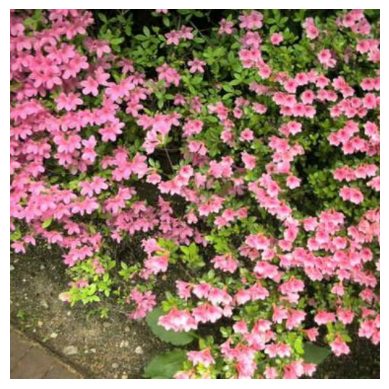

In [37]:
# Can we print out this image using matplot lib?
import matplotlib.pyplot as plt

plt.axis('off')
plt.imshow(image)
print(label)

So we have looked at one specific example, lets try and do this with all out data now that we practiced with TFRecords

### Functionize Getting Dataset based on above the steps should be:
1. Parallel reading on TPU of the TFREcord Filenames
2. According to records, we don't care about order, so with_options(ignore_order) allows us to use data as it streams in
3. MAP the datasets so that we have either a dictionary with (image, label) OR if label doesn't exists (image, id)
4. Deserialize the Image data and save it to an image variable
5. save label to a label variable

In [38]:
CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']  

In [48]:
def labeled_images_parsing(element):
    '''
    This will format our dataset into (image, label) pairs as well as deserialize the image data
    '''
    LABELED_TFREC_FORMAT = {
    "image": tf.io.FixedLenFeature([],tf.string),
    "class": tf.io.FixedLenFeature([],tf.int64)
    }

    example = tf.io.parse_single_example(element,LABELED_TFREC_FORMAT)
    
    image = tf.io.decode_jpeg(example['image'])
    label = tf.cast(example['class'],tf.int32)
    
    return image, label

def unlabeled_images_parsing(element):
    '''
    This will format our dataset into (image, id) pairs as well as deserialize the image data
    '''
    UNLABELED_TFREC_FORMAT = {
    "image": tf.io.FixedLenFeature([],tf.string),
    "id": tf.io.FixedLenFeature([],tf.string)
    }
    
    example = tf.io.parse_single_example(element, UNLABELED_TFREC_FORMAT)
    
    image = tf.io.decode_jpeg(example['image'])
    id_image = tf.cast(example['id'],tf.string)
    
    return image, id_image

In [49]:
# Functionize the process of getting our dataset ready

def load_dataset(filenames, labeled=True, ordered=False):
    '''
    This function will input serialized TFRecord Files, which will then be mapped to a image, label dictionary (if labeled is set to true)
    or id rather than label if labeled is set to false. Order does not matter since we will be shuffling the data anyway.
    '''
    # set Order
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.deterministic = False
    
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads = AUTO) # automatically interleaves reads from multiple records
    dataset = dataset.with_options(ignore_order)
    
    dataset = dataset.map(labeled_images_parsing if labeled else unlabeled_images_parsing, num_parallel_calls = AUTO)
    
    # dataset should be (image,label) OR (image,id) pairs depending on the parameters set
    
    return dataset
    
    

In [50]:
ds_train = load_dataset(TRAINING_FILENAMES)

In [52]:
for image, image_id in ds_train.take(3):
    print(image.numpy().shape, image_id.numpy().shape)

(512, 512, 3) ()
(512, 512, 3) ()
(512, 512, 3) ()


Dataset isn't batched

## Data Pipelines
Now that we can load the dataset we need to create a function that repeats, shuffles, batches, and prefetech new data


In [56]:
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

In [57]:
def get_training_dataset():
    """
    Creates a function to load, batch, shuffle, repeat, and prefetch for training
    """
    
    dataset = load_dataset(TRAINING_FILENAMES, labeled = True)
    dataset = dataset.repeat() # entire training dataset must repeat for epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # while it's training, the next batch can be prepared
    
    return dataset

def get_validation_dataset():
    """
    Creates a function to load, batch, shuffle, repeat, and prefetch for validation
    """
    dataset = load_dataset(VALIDATION_FILENAMES, labeled = True)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    
    return dataset

def get_testing_dataset():
    """
    Creates a function to load, batch, shuffle, repeat, and prefetch for validation
    """
    dataset = load_dataset(TESTING_FILENAMES, labeled = True)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    
    return dataset

In [67]:
ds_train = get_training_dataset()
ds_val = get_validation_dataset()
ds_test = get_testing_dataset()

In [68]:
print("Training data shapes:")
for image, label in ds_train.take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Training data label examples:", label.numpy())

Training data shapes:
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
Training data label examples: [ 13  67  76  43 103  29  83   9  47  15  31  72  47  76  49  47  67  82
  42  93  74   4  13  48  74  55  30  67  80  24   9  17  46 103  87  62
  52  50   0  13 101  71  49  24  93  14   4 103   2  56  79   0  71 103
 103 102 102  47   7  45 103  73  30  18  62  24  50  86 103  87  48  88
  18  53  72  80  53  27  75  83  43  52  37  67  45  50  88  67  92  82
  95  56  49  26 103   0  81  16  67  83 103  73  72  47   4  77  95  28
  19  25  16  72  91  69  50  83  43  82  89  14  11  86  14   1  76  74
  25 103]


In [71]:
ds_train.unbatch().take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, None), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

spear thistle
water lily
columbine


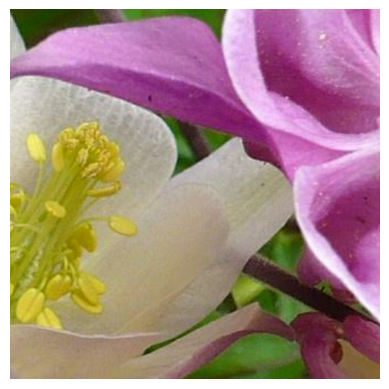

In [77]:
# Can we print out this image using matplot lib?
import matplotlib.pyplot as plt

for index, el in enumerate(ds_train.unbatch().take(3)):
    image, label = el
    print(CLASSES[label])
    plt.axis('off')
    plt.imshow(image)
    